While there exist a wealth of elaborate and abstract NLP techniques, clustering and classification should always be in our toolkit as the first techniques to use when dealing with this kind of data. In addition to being amongst some of the easiest to scale in production, their ease of use can quickly help business address a set of applied problems:

- How do you automatically make the distinction between different categories of sentences?
- How can you find sentences in a dataset that are most similar to a given one?
- How can you extract a rich and concise representation that can then be used for a range of other tasks?
- Most importantly, how do you find quickly whether these tasks are possible on your dataset at all?

While there is a vast amount of resources on classical Machine Learning, or Deep Learning applied to images, I've found that there is a lack of clear, simple guides as to what to do when one wants to find a meaningful representation for sentences (in order to classify them or group them together for examples). Here is my attempt below.

#### ------------------------------------------------------------------------------------------------------------

Ayrıntılı ve soyut NLP teknikleri zenginliği olsa da, bu tür verilerle uğraşırken kullanılacak ilk teknikler olarak kümeleme ve sınıflandırma her zaman alet çantamızda olmalıdır. Üretimde ölçeklendirilmesi en kolay olanlardan biri olmalarının yanı sıra kullanım kolaylıkları, işletmenin bir dizi uygulamalı sorunu hızlı bir şekilde çözmesine yardımcı olabilir:

- Farklı cümle kategorileri arasındaki ayrımı otomatik olarak nasıl yaparsınız?
- Belirli bir veri setine en çok benzeyen cümleleri bir veri setinde nasıl bulabilirsiniz?
- Daha sonra bir dizi başka görev için kullanılabilecek zengin ve özlü bir temsili nasıl elde edebilirsiniz?
- En önemlisi, bu görevlerin veri kümenizde mümkün olup olmadığını hızlı bir şekilde nasıl anlarsınız?

Klasik Makine Öğrenimi veya görüntülere uygulanan Derin Öğrenme hakkında çok miktarda kaynak olsa da, cümleler için anlamlı bir temsil bulmak istediğinde ne yapılması gerektiğine dair net, basit kılavuzların eksikliğini gördüm ( sınıflandırmak veya örnekler için birlikte gruplandırmak amacıyla). İşte girişimim aşağıda.

### Our Dataset: Disasters on social media/Veri Setimiz: Sosyal medyadaki afetler
Contributors looked at over 10,000 tweets retrieved with a variety of searches like “ablaze”, “quarantine”, and “pandemonium”, then noted whether the tweet referred to a disaster event (as opposed to a joke with the word or a movie review or something non-disastrous). 

Katkıda bulunanlar, "alevlenmek", "karantina" ve "pandemonium" gibi çeşitli aramalarla alınan 10.000'den fazla tweet'e baktılar ve ardından tweet'in bir felaket olayına atıfta bulunup bulunmadığına dikkat ettiler (şaka veya film incelemesi veya felaket olmayan bir şey).

### Why it matters/neden önemli
We will try to correctly predict tweets that are about disasters. This is a very relevant problem, because:
- It is actionable to anybody trying to get signal from noise (such as police departments in this case)
- It is tricky because relying on keywords is harder than in most cases like spam

Afetlerle ilgili tweetleri doğru tahmin etmeye çalışacağız. Bu çok ilgili bir sorun çünkü:
- Gürültüden sinyal almaya çalışan herkes için dava edilebilir (bu durumda polis departmanları gibi)
- Zor, çünkü anahtar kelimelere güvenmek spam gibi çoğu durumda olduğundan daha zor.

In [28]:
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs

### Sanitizing input/Sanitasyon girişi
Let's make sure our tweets only have characters we want. We remove '#' characters but keep the words after the '#' sign because they might be relevant (eg: #disaster)

Tweetlerimizde sadece istediğimiz karakterlerin olmasına dikkat edelim. '#' Karakterlerini kaldırıyoruz ancak alakalı olabilecekleri için '#' işaretinden sonraki kelimeleri tutuyoruz (örneğin: #felaket)

In [29]:
import codecs

input_file = codecs.open("socialmedia_relevant_cols.csv", "r", encoding='utf-8', errors='replace')
output_file = open("socialmedia_relevant_cols_clean.csv", "w", encoding='utf-8')

def sanitize_characters(raw, clean):    
    for line in input_file:
        out = line
        output_file.write(line)

sanitize_characters(input_file, output_file)


### Let's inspect the data/Verileri inceleyelim
It looks solid, but we don't really need urls, and we would like to have our words all lowercase (Hello and HELLO are pretty similar for our task)

Sağlam görünüyor, ancak gerçekten URL'lere ihtiyacımız yok ve kelimelerimizin tamamen küçük olmasını istiyoruz (Merhaba ve HELLO, görevimiz için oldukça benzerdir)

In [30]:
questions = pd.read_csv("socialmedia_relevant_cols_clean.csv")
questions.columns=['text', 'choose_one', 'class_label']
questions.head()

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


In [31]:
questions.tail()

,text,choose_one,class_label
10776,Wreckage 'Conclusively Confirmed' as From MH37...,Relevant,1
10777,Wreckage 'Conclusively Confirmed' as From MH37...,Relevant,1
10778,Wreckage 'Conclusively Confirmed' as From MH37...,Relevant,1
10779,Wreckage 'Conclusively Confirmed' as From MH37...,Relevant,1
10780,Wreckage 'Conclusively Confirmed' as From MH37...,Relevant,1


In [32]:
questions.describe()

,class_label
count,10781.000000
mean,0.432056
std,0.498372
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


Let's use a few regular expressions to clean up pour data, and save it back to disk for future use

Dökme verilerini temizlemek için birkaç normal ifade kullanalım ve ileride kullanmak üzere tekrar diske kaydedelim

In [33]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

questions = standardize_text(questions, "text")

questions.to_csv("clean_data.csv")
questions.head()

C:\Users\Serkan POLAT\AppData\Local\Temp\ipykernel_3328\1989450400.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df[text_field] = df[text_field].str.replace(r"http\S+", "")
C:\Users\Serkan POLAT\AppData\Local\Temp\ipykernel_3328\1989450400.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df[text_field] = df[text_field].str.replace(r"@\S+", "")
C:\Users\Serkan POLAT\AppData\Local\Temp\ipykernel_3328\1989450400.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")


,text,choose_one,class_label
0,just happened a terrible car crash,Relevant,1
1,our deeds are the reason of this earthquake m...,Relevant,1
2,"heard about earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,forest fire near la ronge sask canada,Relevant,1


In [34]:
clean_questions = pd.read_csv("clean_data.csv")
clean_questions.tail()

,Unnamed: 0,text,choose_one,class_label
10776,10776,wreckage 'conclusively confirmed' as from mh37...,Relevant,1
10777,10777,wreckage 'conclusively confirmed' as from mh37...,Relevant,1
10778,10778,wreckage 'conclusively confirmed' as from mh37...,Relevant,1
10779,10779,wreckage 'conclusively confirmed' as from mh37...,Relevant,1
10780,10780,wreckage 'conclusively confirmed' as from mh37...,Relevant,1


### Data Overview/Verilere Genel Bakış

Let's look at our class balance.

Sınıf dengemize bakalım.

In [35]:
clean_questions.groupby("class_label").count()

,Unnamed: 0,text,choose_one
class_label,,,
0,6139,6139,6139
1,4626,4626,4626
2,16,16,16


We can see our classes are pretty balanced, with a slight oversampling of the "Irrelevant" class.

"Irrelevant" sınıfının biraz fazla örneklenmesiyle, sınıflarımızın oldukça dengeli olduğunu görebiliriz.

### Our data is clean, now it needs to be prepared/Verilerimiz temiz, şimdi hazırlanması gerekiyor
Now that our inputs are more reasonable, let's transform our inputs in a way our model can understand. This implies:
- Tokenizing sentences to a list of separate words
- Creating a train test split
- Inspecting our data a little more to validate results

#### --------------------------------
Artık girdilerimiz daha makul olduğuna göre girdilerimizi modelimizin anlayabileceği şekilde dönüştürelim. Bu şu anlama gelir:
- Cümleleri ayrı kelimelerden oluşan bir listeye ayırma
- Bir tren testi bölümü oluşturma
- Sonuçları doğrulamak için verilerimizi biraz daha incelemek

In [36]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)
clean_questions.head()

,Unnamed: 0,text,choose_one,class_label,tokens
0,0,just happened a terrible car crash,Relevant,1,"[just, happened, a, terrible, car, crash]"
1,1,our deeds are the reason of this earthquake m...,Relevant,1,"[our, deeds, are, the, reason, of, this, earth..."
2,2,"heard about earthquake is different cities, s...",Relevant,1,"[heard, about, earthquake, is, different, citi..."
3,3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, is, a, forest, fire, at, spot, pond, g..."
4,4,forest fire near la ronge sask canada,Relevant,1,"[forest, fire, near, la, ronge, sask, canada]"


In [37]:
!pip install --upgrade keras


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Inspecting our dataset a little more/Veri setimizi biraz daha inceliyoruz

In [38]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

153495 words total, with a vocabulary size of 18044
Max sentence length is 34


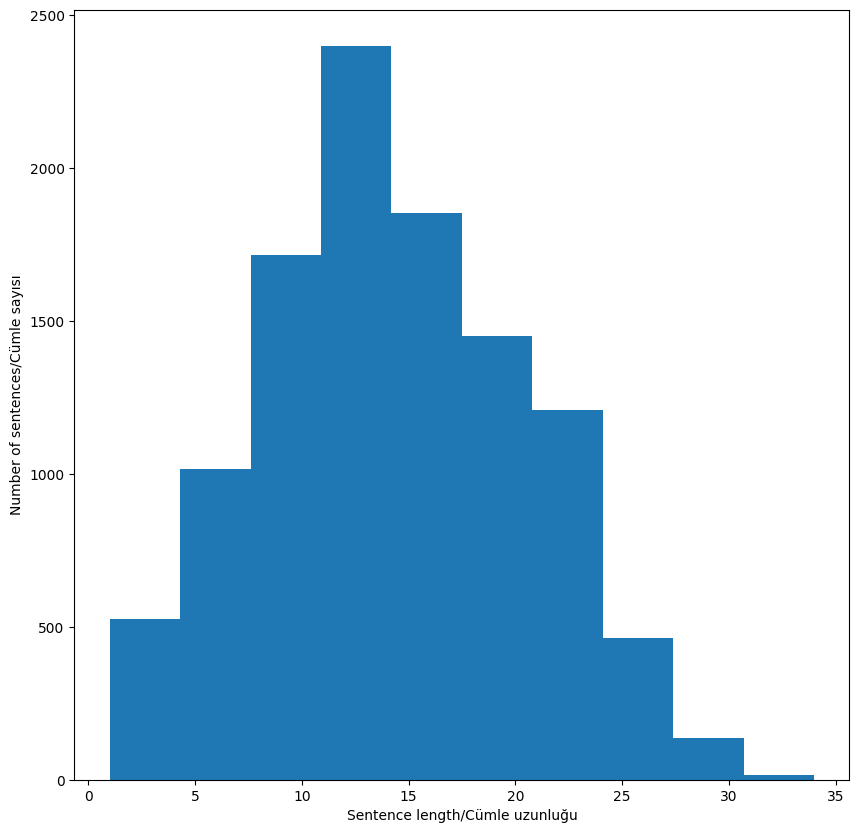

In [39]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length/Cümle uzunluğu')
plt.ylabel('Number of sentences/Cümle sayısı')
plt.hist(sentence_lengths)
plt.show()

## On to the Machine Learning/Makine Öğrenimine Açık
Now that our data is clean and prepared, let's dive in to the machine learning part.

Artık verilerimiz temiz ve hazır olduğuna göre, makine öğrenimi kısmına geçelim.

## Enter embeddings/Yerleştirmeleri girin
 Machine Learning on images can use raw pixels as inputs. Fraud detection algorithms can use customer features. What can NLP use?
 
A natural way to represent text for computers is to encode each character individually, this seems quite inadequate to represent and understand language. Our goal is to first create a useful embedding for each sentence (or tweet) in our dataset, and then use these embeddings to accurately predict the relevant category.

The simplest approach we can start with is to use a bag of words model, and apply a logistic regression on top. A bag of words just associates an index to each word in our vocabulary, and embeds each sentence as a list of 0s, with a 1 at each index corresponding to a word present in the sentence.

##### ------------------------------------------ 

Görüntülerde Makine Öğrenimi, girdi olarak ham pikselleri kullanabilir. Dolandırıcılık tespit algoritmaları müşteri özelliklerini kullanabilir. NLP ne kullanabilir?
 
Bilgisayarlar için metni temsil etmenin doğal bir yolu, her karakteri ayrı ayrı kodlamaktır, bu, dili temsil etmek ve anlamak için oldukça yetersiz görünmektedir. Amacımız, öncelikle veri kümemizdeki her cümle (veya tweet) için yararlı bir yerleştirme oluşturmak ve ardından ilgili kategoriyi doğru bir şekilde tahmin etmek için bu yerleştirmeleri kullanmaktır.

Başlayabileceğimiz en basit yaklaşım, bir kelime torbası modeli kullanmak ve üstüne bir lojistik regresyon uygulamaktır. Bir kelime torbası, kelime dağarcığımızdaki her kelimeyle bir dizin ilişkilendirir ve her cümleyi, cümlede bulunan bir kelimeye karşılık gelen her dizinde 1 olacak şekilde 0'lar listesi olarak yerleştirir.

## Bag of Words Counts/Sözcük Torbası Önemlidir

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = clean_questions["text"].tolist()
list_labels = clean_questions["class_label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

### Visualizing the embeddings/Yerleştirmeleri görselleştirme
Now that we've created embeddings, let's visualize them and see if we can identify some structure. In a perfect world, our embeddings would be so distinct that are two classes would be perfectly separated. Since visualizing data in 20k dimensions is hard, let's project it down to 2.

Gömmeler oluşturduğumuza göre, onları görselleştirelim ve bir yapı tanımlayıp tanımlayamayacağımıza bakalım. Mükemmel bir dünyada, yerleşimlerimiz o kadar farklı olurdu ki, iki sınıf mükemmel bir şekilde ayrılırdı. 20k boyutlu verileri görselleştirmek zor olduğu için 2'ye indirelim.

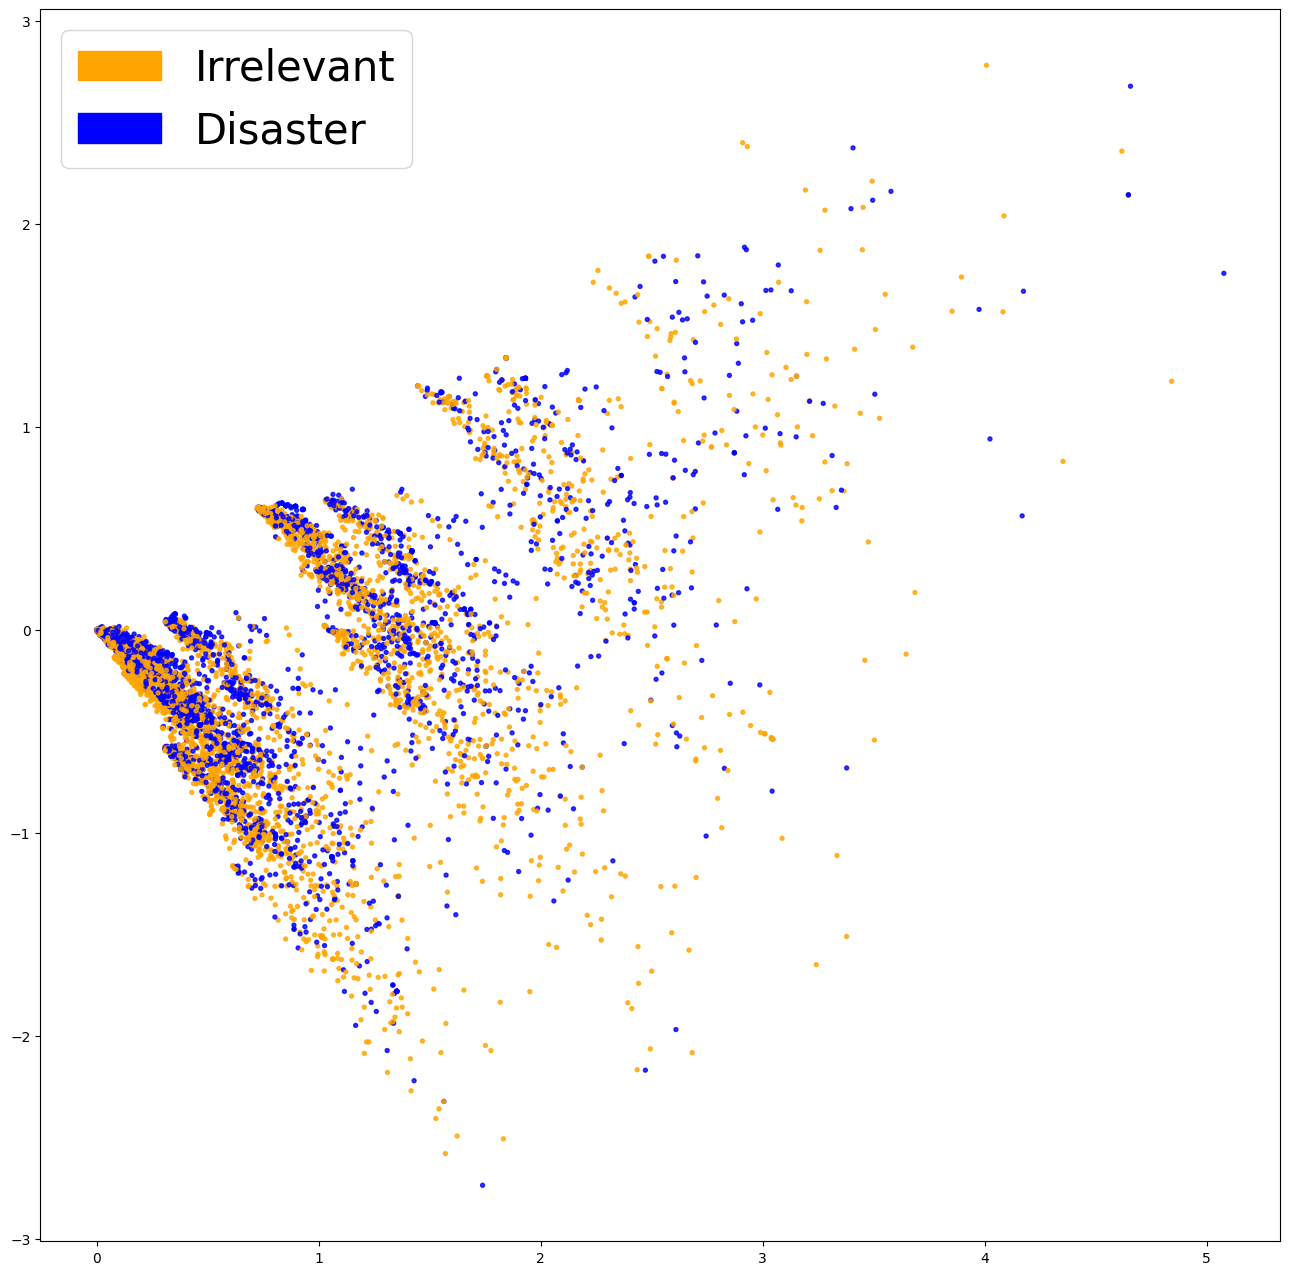

In [41]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

These embeddings don't look very cleanly separated. Let's see if we can still fit a useful model on them.

Bu yerleştirmeler çok temiz bir şekilde ayrılmış görünmüyor. Bakalım onlara hala kullanışlı bir model uydurabilecek miyiz?

### Fitting a classifier/Bir sınıflandırıcının takılması
Starting with a logistic regression is a good idea. It is simple, often gets the job done, and is easy to interpret.

Lojistik bir gerileme ile başlamak iyi bir fikirdir. Basittir, genellikle işi halleder ve yorumlanması kolaydır.

In [42]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

### Evaluation/Değerlendirme
Let's start by looking at some metrics to see if our classifier performed well at all.

Sınıflandırıcımızın iyi performans gösterip göstermediğini görmek için bazı ölçümlere bakarak başlayalım.

In [43]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.778, precision = 0.777, recall = 0.778, f1 = 0.777


### Inspection/Denetleme
A metric is one thing, but in order to make an actionnable decision, we need to actually inspect the kind of mistakes our classifier is making. Let's start by looking at the confusion matrix.

Metrik bir şeydir, ancak eyleme geçirilebilir bir karar vermek için sınıflandırıcımızın yaptığı hataları gerçekten incelememiz gerekir. Karışıklık matrisine bakarak başlayalım.

In [44]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

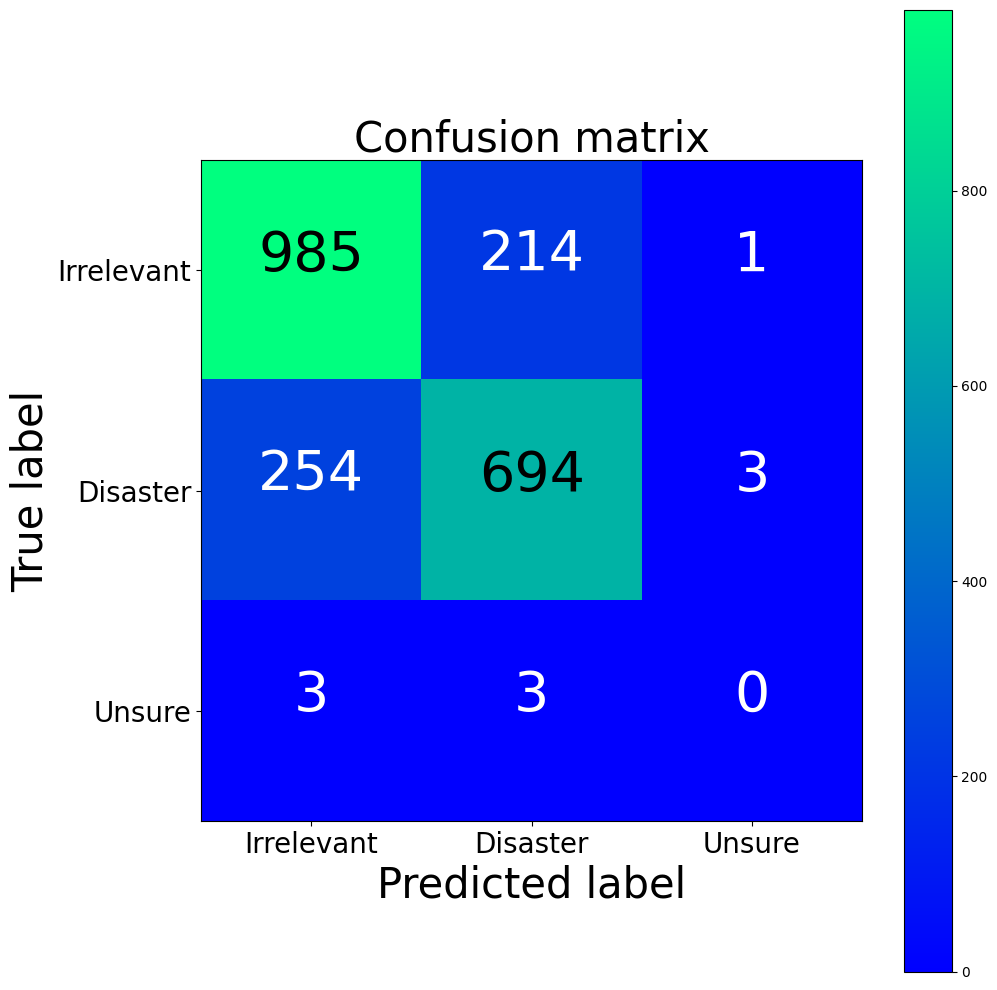

[[985 214   1]
 [254 694   3]
 [  3   3   0]]


In [45]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

Our classifier never predicts class 3, which is not surprising, seeing as it is critically undersampled. This is not very important here, as the label is not very meaningful. Our classifier creates more false negatives than false positives (proportionally). Depending on the use case, this seems desirable (a false positive is quite a high cost for law enforcement for example).

Sınıflandırıcımız hiçbir zaman sınıf 3'ü tahmin etmez ki bu, kritik derecede yetersiz örneklendiği için şaşırtıcı değildir. Etiket çok anlamlı olmadığı için burada bu çok önemli değil. Sınıflandırıcımız, yanlış pozitiflerden (orantılı olarak) daha fazla yanlış negatif oluşturur. Kullanım durumuna bağlı olarak, bu arzu edilir görünmektedir (örneğin, yanlış bir pozitif, kolluk kuvvetleri için oldukça yüksek bir maliyettir).

### Further inspection/Daha fazla inceleme
Let's look at the features our classifier is using to make decisions.

Sınıflandırıcımızın karar vermek için kullandığı özelliklere bakalım.

In [46]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

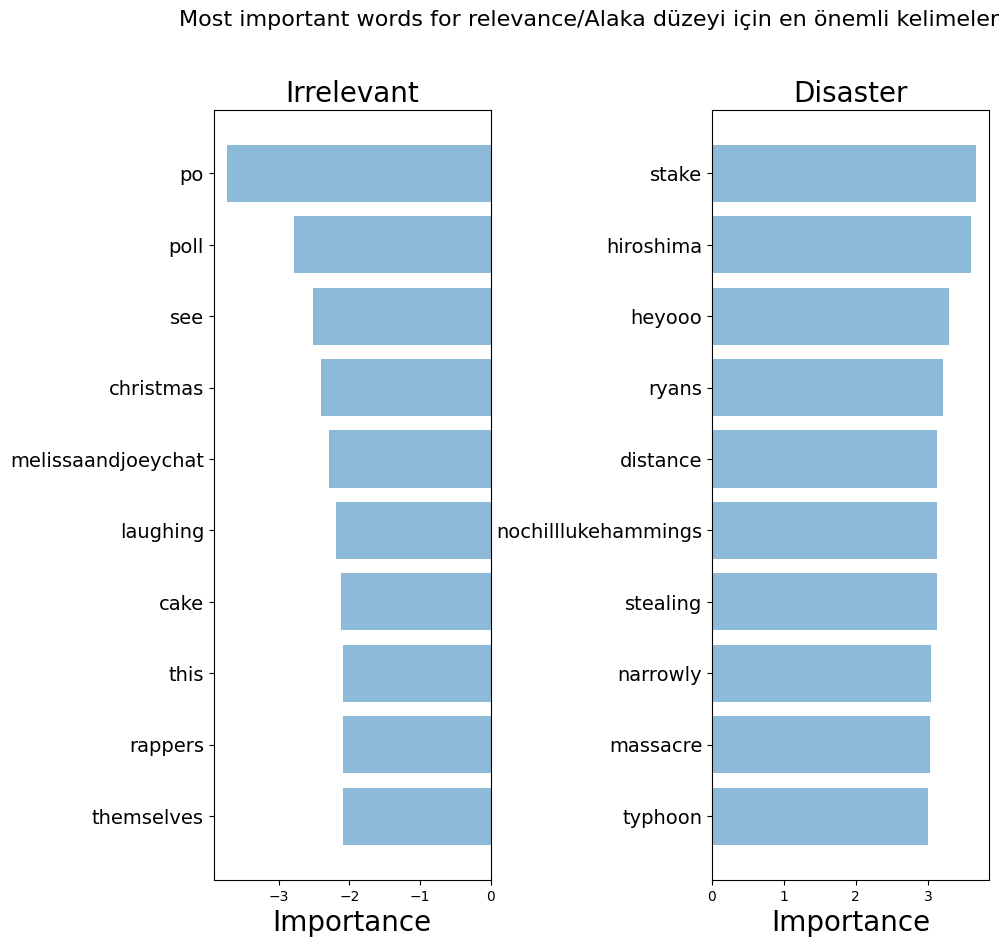

In [47]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance/Alaka düzeyi için en önemli kelimeler")

Our classifier correctly picks up on some patterns (hiroshima, massacre), but clearly seems to be overfitting on some irellevant terms (heyoo, x1392)

Sınıflandırıcımız bazı kalıpları (hiroşima, katliam) doğru bir şekilde alıyor, ancak bazı alakasız terimlere (heyoo, x1392) fazla uyuyor gibi görünüyor.

### TFIDF Bag of Words
Let's try a slightly more subtle approach. On top of our bag of words model, we use a TF-IDF (Term Frequency, Inverse Document Frequency) which means weighing words by how frequent they are in our dataset, discounting words that are too frequent, as they just add to the noise.

Biraz daha incelikli bir yaklaşım deneyelim. Kelime torbası modelimize ek olarak, kelimeleri veri kümemizde ne sıklıkta olduklarına göre tartmak, çok sık olan kelimeleri sadece gürültüyü artırdıkları için dikkate almamak anlamına gelen bir TF-IDF (Terim Frekansı, Ters Belge Frekansı) kullanıyoruz. .

In [48]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

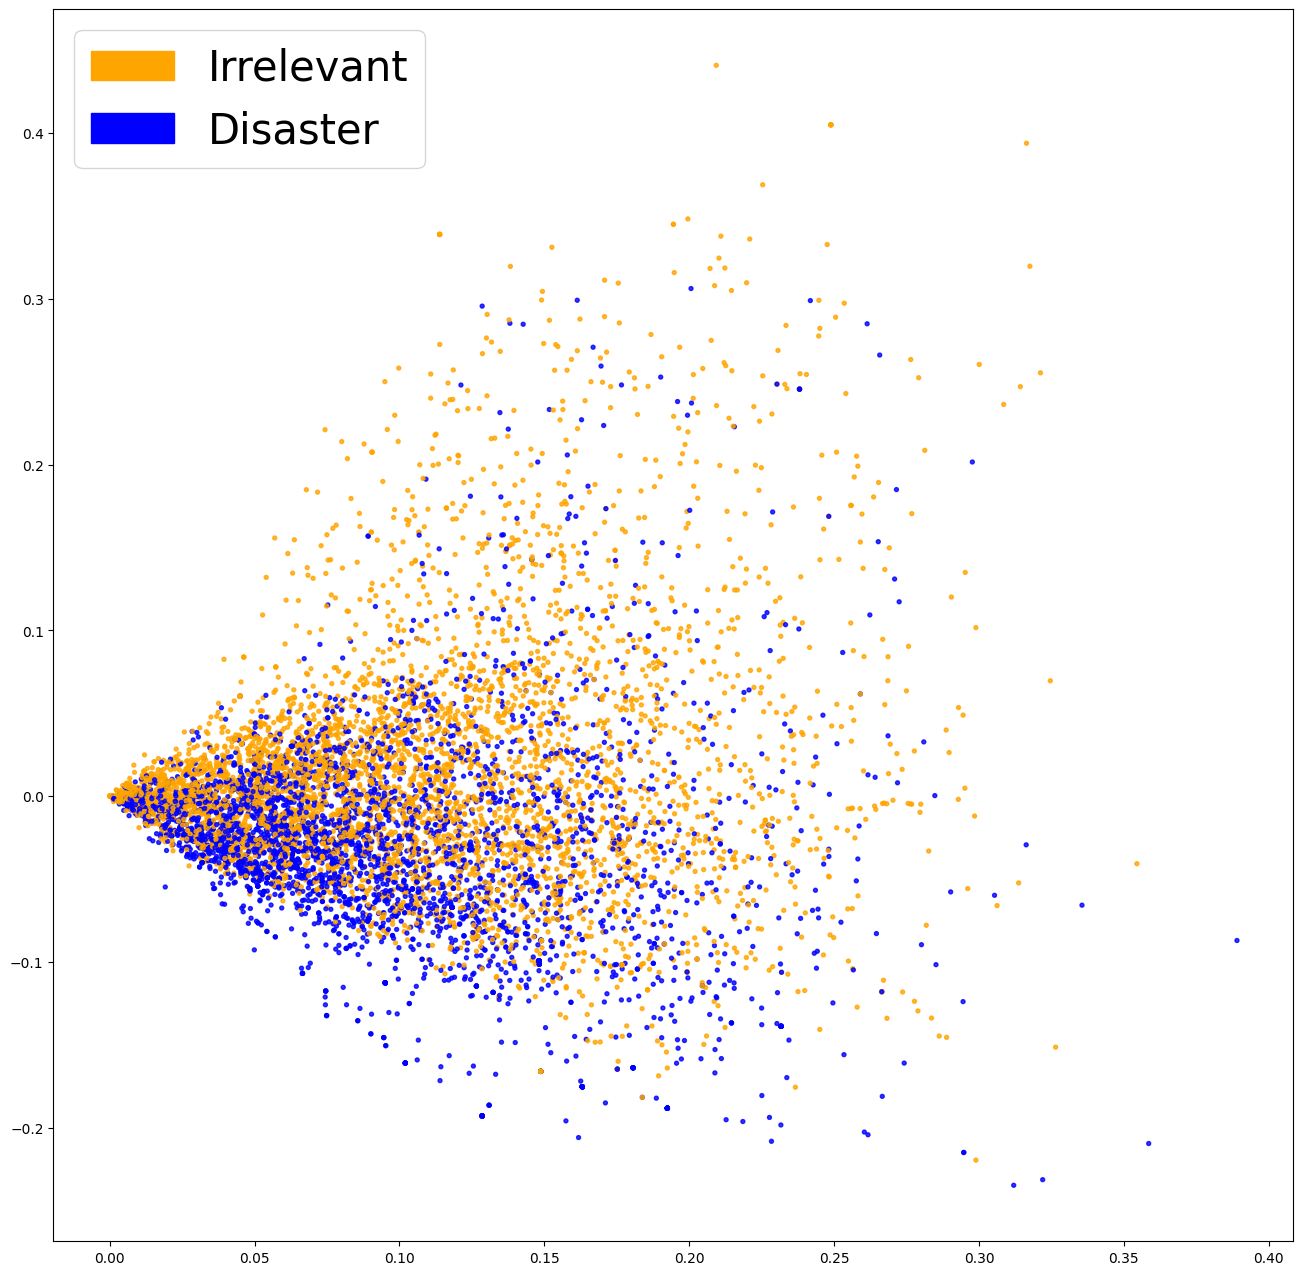

In [49]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

These embeddings look much more separated, let's see if it leads to better performance.

Bu gömmeler çok daha ayrı görünüyor, bakalım daha iyi performans sağlıyor mu?

In [50]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [51]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.780, precision = 0.778, recall = 0.780, f1 = 0.779


c:\Users\Serkan POLAT\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The results are a little better, let's see if they translate to an actual difference in our use case.

Sonuçlar biraz daha iyi, bakalım kullanım durumumuzda gerçek bir farka dönüşecek mi?

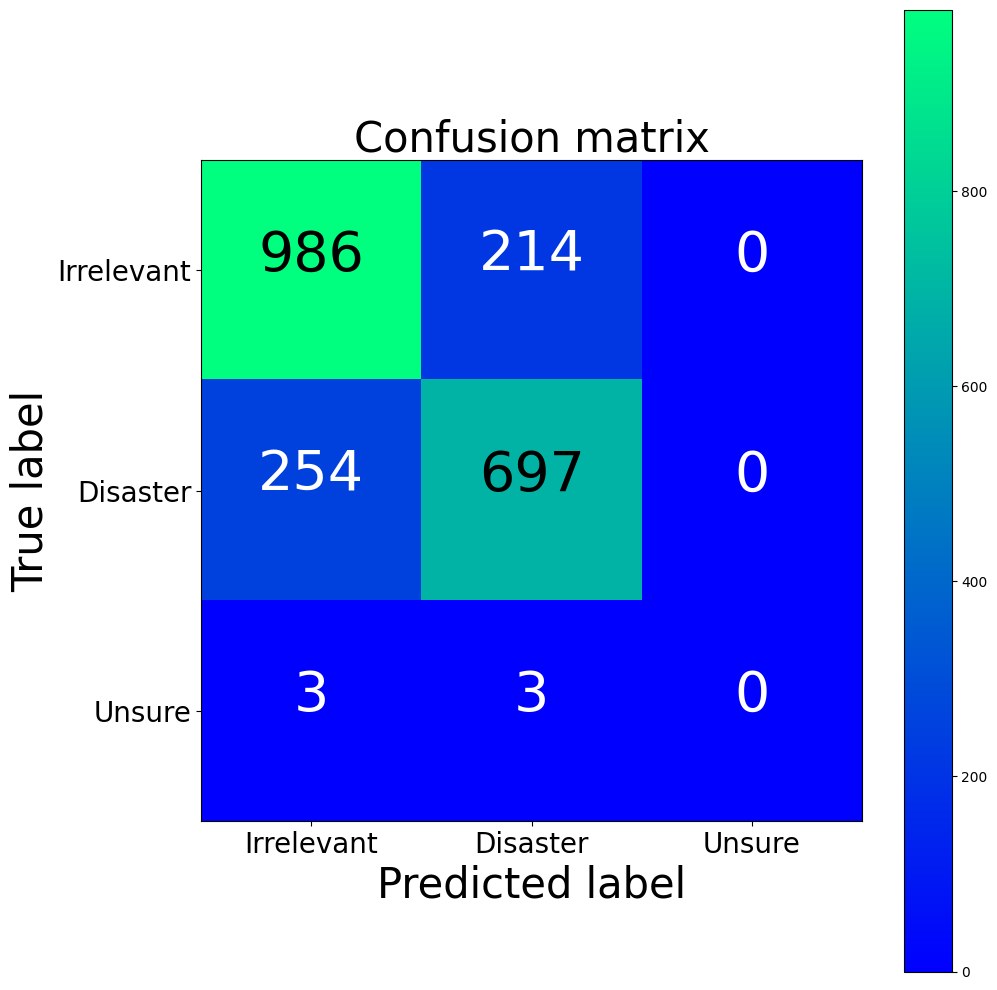

TFIDF confusion matrix
[[986 214   0]
 [254 697   0]
 [  3   3   0]]
BoW confusion matrix
[[985 214   1]
 [254 694   3]
 [  3   3   0]]


In [52]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

Our False positives have decreased, as this model is more conservative about choosing the positive class.

Bu model pozitif sınıfı seçme konusunda daha muhafazakar olduğu için Yanlış pozitiflerimiz azaldı.

# Looking at important coefficients for linear regression/Lineer regresyon için önemli katsayılara bakmak
Insert details here

Ayrıntıları buraya girin

In [53]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

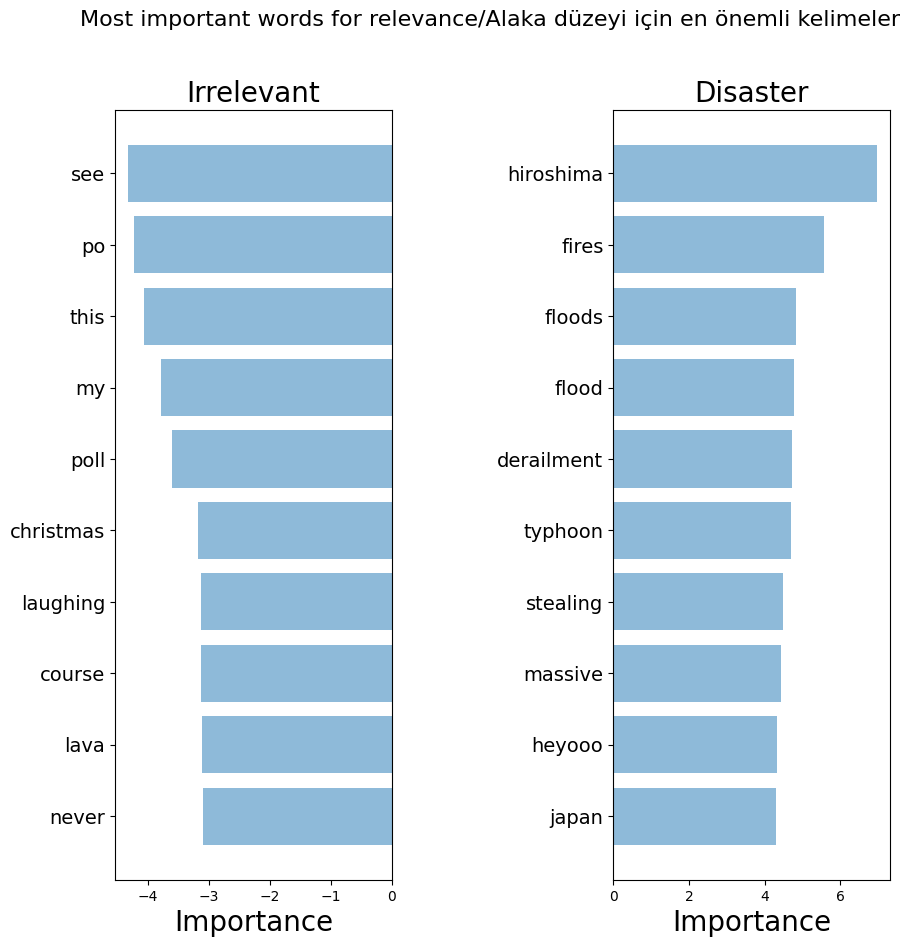

In [54]:
top_scores = [a[0] for a in importance_tfidf[1]['tops']]
top_words = [a[1] for a in importance_tfidf[1]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[1]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance/Alaka düzeyi için en önemli kelimeler")

The words it picked up look much more relevant! Although our metrics on our held out validation set haven't increased much, we have much more confidence in the terms our model is using, and thus would feel more comfortable deploying it in a system that would interact with customers.

Aldığı kelimeler çok daha alakalı görünüyor! Uzatılan doğrulama kümemizdeki ölçümlerimiz çok fazla artmamış olsa da, modelimizin kullandığı terimlere çok daha fazla güveniyoruz ve bu nedenle, onu müşterilerle etkileşim kuracak bir sistemde devreye alma konusunda kendimizi daha rahat hissedeceğiz.

In [55]:
!pip install -upgrade keras


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -u


## What about text generation?/Peki ya metin üretimi?
Most practical problems fall within the buckets of organizing or classifying text data. However, in some cases like automated support systems, or translation, generating text is necessary. One of the best methods to accomplish this is to use a Recurrent Neural Network as a language model. Training these models is quite difficult, and usually very long. Since we will not have time to train one here, below is an example of a pre-trained model.

Pratik problemlerin çoğu, metin verilerini düzenleme veya sınıflandırma kovalarına girer. Ancak, otomatik destek sistemleri veya çeviri gibi bazı durumlarda metin oluşturmak gereklidir. Bunu gerçekleştirmenin en iyi yöntemlerinden biri, dil modeli olarak Tekrarlayan Sinir Ağını kullanmaktır. Bu modelleri eğitmek oldukça zordur ve genellikle çok uzundur. Burada eğitmek için zamanımız olmayacağından, aşağıda önceden eğitilmiş bir model örneği verilmiştir.


## Yelp review generation/Yelp incelemesi oluşturma


 This is a character-level Recurrent Neural Network model trained by Andrew Manser (an Insight Fellow), during his time at insight. He trained it exclusively on 5 star reviews from the open Yelp dataset for multiple weeks, to get to the demonstrated level of fluency

Bu, Andrew Manser (bir Insight Fellow) tarafından, kendi öngörüsü sırasında eğitilmiş, karakter seviyesinde bir Tekrarlayan Sinir Ağı modelidir. Kanıtlanmış akıcılık düzeyine ulaşmak için onu yalnızca açık Yelp veri kümesindeki 5 yıldızlı incelemelerle birkaç hafta boyunca eğitti.

In [56]:
from tensorflow import keras
import sys

# Dictionary mapping unique characters to their index in `chars`
text=open('seed_text.txt').read()
chars=['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~']

char_indices = dict((char, chars.index(char)) for char in chars)
maxlen=60
step=1

model = keras.models.Sequential()
model.add(layers.LSTM(1024, input_shape=(maxlen, len(chars)),return_sequences=True))
model.add(layers.LSTM(1024, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.load_weights("Sep-26-all-00-0.7280.hdf5")

optimizer = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)


In [57]:
import numpy as np 
import pandas as pd
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def random_reviews():
    start_index = np.random.randint(0, len(text) - maxlen - 1)
    generated_text = text[start_index: start_index + maxlen]
    print('Coming up with several reviews for you/Sizin için birkaç inceleme ile geliyor...')

    for temperature in [0.8]:
        sys.stdout.write(generated_text)

        # We generate 600 characters
        for i in range(600):
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print(generated_text)

In [58]:
random_reviews()

Coming up with several reviews for you/Sizin için birkaç inceleme ile geliyor...
ust something to help the model get started!  You can use an a

C:\Users\Serkan POLAT\AppData\Local\Temp\ipykernel_3328\174017954.py:5: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature


ppetizer I can't wait to go back and try more then the beef pho noodle soup and salad is a must.<EOR>"
"<SOR>the only place in town for a car to get to go ti i for dinner before they were in Vegas.<EOR>"
"<SOR>Friendly staff!                                          versiration de la comida melicios de la ride ridiculous   t tait mais une vien en sabor es en rien buen pat.<EOR>"
"<SOR>What a great place to hangout and eat the first time is gonna get the wonderful sushi in many types of restaurants.<EOR>"
"<SOR>I was in a review in a roman location.  the workers were friendly and seem to get  roman location.  the workers were friendly and seem to get 


# Making Deep Learning models better/Derin Öğrenme modellerini daha iyi hale getirme

To help elaborate deep learning models get to a polished state, it is usually useful to add hand-crafter rules on top. Here, we substitute food words in the generated reviews for ones from a pre-established list.

Ayrıntılı derin öğrenme modellerinin gösterişli bir duruma gelmesine yardımcı olmak için genellikle en üste el işi kuralları eklemek yararlıdır. Burada, önceden belirlenmiş bir listeden olanların yerine oluşturulan incelemelerdeki yiyecek kelimelerini değiştiriyoruz.

In [59]:
from nltk.corpus import wordnet as wn

def food_related(nouns):

    food=wn.synset('food.n.01')
    final_list=[]
    for word in nouns:
        temp=word
        word=word+'.n.01'
        try:
            if food.wup_similarity(wn.synset(word))>0.20 and temp!='food':
                final_list.append(temp)
        except:
            pass

    return final_list

def user_custom(foods):
    # enter foods as a string separated by commas. For example 'sushi, sashimi, maki'/yiyecekleri virgülle ayrılmış bir dizi olarak girin. Örneğin 'sushi, sashimi, maki'
    start_index = np.random.randint(0, len(text) - maxlen - 1)
    generated_text = text[start_index: start_index + maxlen]
    print('Coming up with two ideas for you/Sizin için iki fikir buluyorum...')

    final=generated_text+''

    for temperature in [0.8]:


        # We generate 600 characters/600 karakter üretiyoruz
        for i in range(600):
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]
            final+=next_char

            generated_text += next_char
            generated_text = generated_text[1:]
    
    #print first review, then second via SOR/EOR/ilk incelemeyi yazdırın, ardından SOR/EOR ​​aracılığıyla ikinci incelemeyi yazdırın
    temp=personalized_clean_up(final, foods)
    start=temp.find('SOR')
    stop=findStrAfterStr(temp, 'EOR', 'SOR')
    end_first=temp[start+4:stop]

    new=temp[get_second_index(temp, 'SOR')+4:]
    ending=new.find('EOR')
    print(temp[start+4:stop])
    print("")
    print(new[:ending])
    
def personalized_clean_up(review,user_items):
    #take generic review, and replace with user generated words/genel inceleme yapın ve kullanıcı tarafından oluşturulan kelimelerle değiştirin
    generic_nouns=review_to_nouns(review)
    food_generic=food_related(generic_nouns)

    user_picked_items=user_items.split(",")

    final=[]
    for word in re.findall(r"[\w']+|[.,!?;]", review):
        if word in food_generic and len(user_picked_items)>1:
            word=np.random.choice(user_picked_items)
            final.append(word)
        else:
            final.append(word)

    new_review=" ".join(final)
    return re.sub(r'\s+([?.!",])', r'\1', new_review)

def review_to_nouns(review):
    is_noun = lambda pos: pos[:2] == 'NN'
    token=nltk.word_tokenize(review)
    nouns=[word for (word, pos) in nltk.pos_tag(token) if is_noun(pos)]
    return nouns

def findStrAfterStr(myString, searchText, afterText):
    after_index = myString.index(afterText)
    return myString.find(searchText, after_index)

def get_second_index(input_string, sub_string):
    return input_string.index(sub_string, input_string.index(sub_string) + 1)

In [60]:
import nltk
import re
user_custom('burrito, taco, guac')


Coming up with two ideas for you/Sizin için iki fikir buluyorum...


C:\Users\Serkan POLAT\AppData\Local\Temp\ipykernel_3328\174017954.py:5: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature


The service was good. especially toppings and cream so delicious! my go to is always my favorite  taco  taco. in my  guac they have a  guac burrito and too many sandwiches. 

the  taco is handing mades one of the best in  guac was a bit of the large with the  guac palat
